In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [3]:
results_paths={}

results_paths['context_all_trials_no_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_10ms_no_baseline_subtract_0/"
results_paths['context_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0/"

results_paths['response_all_trials_no_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_no_baseline_subtract_0/"
results_paths['response_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0/"

results_paths['aud_stim_all_blocks'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_0/"
results_paths['aud_stim_all_blocks_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_baseline_subtract_0/"

results_paths['vis_stim_all_blocks'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_0/"
results_paths['vis_stim_all_blocks_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_baseline_subtract_0/"

In [4]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [5]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle keep_original_structure
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)

# map structures to grouped structures
# SCop, SCsg, SCzo -> SCs
# SCig, SCiw, SCdg, SCdw -> SCm
# ECT1, ECT2/3, ECT6b, ECT5, ECT6a, ECT4 -> ECT
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}


In [6]:
# get result-wise predict proba dataframes

def get_predict_proba_results_df(results_path, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping, predict_proba_alias='predict_proba'):

    structure_grouping = {
        'SCop': 'SCs',
        'SCsg': 'SCs',
        'SCzo': 'SCs',
        'SCig': 'SCm',
        'SCiw': 'SCm',
        'SCdg': 'SCm',
        'SCdw': 'SCm',
        "ECT1": 'ECT',
        "ECT2/3": 'ECT',    
        "ECT6b": 'ECT',
        "ECT5": 'ECT',
        "ECT6a": 'ECT', 
        "ECT4": 'ECT',
    }
    keep_original_structure = False
    if keep_original_structure:
        n_repeats = 2
    else:
        n_repeats = 1

    predict_proba_wo_repeats = (
        pl.scan_parquet(results_path)
        #make new column that indicates whether a row is the sole recording from a structure in a session
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
        )
        #Grab only rows according to combine_multi_probe_rec toggle
        #Grab only rows that have is_all_trials == True, only these have predict_proba
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials'),
        )
        #join on the units table to get total number of units per structure
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                )
                #make new rows according to structure_grouping
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                    .then(pl.col('structure').repeat_by(n_repeats))
                    .otherwise(pl.col('structure').repeat_by(1))
                )
                .explode('structure')
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                    .then(pl.col('structure').replace(structure_grouping))
                    .otherwise(pl.col('structure'))
                )
                .group_by('session_id','structure')
                .agg(
                    pl.col('unit_id').len().alias('total_n_units')
                )
            ),
            on=['session_id','structure'],
            how='left',
        )
        .with_columns(
            #pl.int_ranges(0, pl.col(predict_proba_alias).list.len()).alias('trial_index')
            pl.col('trial_indices').alias('trial_index')
        )
        .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
        .explode(predict_proba_alias, 'trial_index')
        .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
        .agg(
            pl.col('balanced_accuracy_test').mean(),
            pl.col(predict_proba_alias).mean().alias('predict_proba'),
            pl.col('total_n_units').first(),
            # pl.col('unit_ids').first(),
        )
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                    #iti column?
                )
                .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
            ),
            on=['session_id','trial_index'],
            how='inner',
        ) 
        .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
        .agg(
            pl.col('balanced_accuracy_test').first(),
            pl.col('total_n_units').first(),
            # pl.col('unit_ids').first(),
            pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

        )
        .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
        # .group_by('session_id','structure')
        .collect(engine='streaming')
    )

    return predict_proba_wo_repeats.to_pandas()

In [16]:
results_dfs={}
for key, results_path in results_paths.items():
    print(f"Loading results from {key}...")
    results_dfs[key] = get_predict_proba_results_df(results_path, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping, predict_proba_alias='predict_proba')

Loading results from context_all_trials_no_baseline_subtract...
Loading results from context_all_trials...
Loading results from response_all_trials_no_baseline_subtract...
Loading results from response_all_trials...
Loading results from aud_stim_all_blocks...
Loading results from aud_stim_all_blocks_baseline_subtract...
Loading results from vis_stim_all_blocks...
Loading results from vis_stim_all_blocks_baseline_subtract...


In [ ]:
#save individual dfs from resuts_dfs as parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22"

for key, df in results_dfs.items():
    df.to_parquet(os.path.join(savepath, f"{key}_decoding_predict_proba_table.parquet"))


In [12]:
#load results from parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22"
results_dfs={}
for filename in os.listdir(savepath):
    if filename.endswith("_decoding_predict_proba_table.parquet"):
        key = filename.replace("_decoding_predict_proba_table.parquet", "")
        df = pd.read_parquet(os.path.join(savepath, filename))
        results_dfs[key] = df

In [8]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect()#.to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect()#.to_pandas()

In [12]:
results_dfs[key].columns

Index(['session_id', 'structure', 'unit_subsample_size', 'bin_center',
       'time_aligned_to', 'balanced_accuracy_test', 'total_n_units',
       'predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name',
       'is_response'],
      dtype='object')

In [ ]:
# find averages across trial types of interest by session

#extend below code to get averages for each result

In [9]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """
    
    if sel_time_aligned_to=='response_time':
        if sel_unit_subsample_size=='all':
            temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="stim_start_time" and unit_subsample_size.isna()'
                                                        ).sort_values('bin_center').iloc[0]
        else:
            temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').iloc[0]
        
        trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
        is_vis_rewarded=temp_trial_info['is_vis_rewarded'][temp_trial_info['is_response']]
        stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
        is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]
        
        if sel_unit_subsample_size=='all':
            example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="response_time" and unit_subsample_size.isna()'
                                                        ).sort_values('bin_center').reset_index(drop=True)
        else:
            example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                        ).sort_values('bin_center').reset_index(drop=True)
        trial_index_list=[]
        is_vis_rewarded_list=[]
        stim_name_list=[]
        is_response_list=[]
        for rr in range(len(example_area_results)):
            trial_index_list.append(trial_index)
            is_vis_rewarded_list.append(is_vis_rewarded)
            stim_name_list.append(stim_name)
            is_response_list.append(is_response)

        example_area_results['trial_index']=trial_index_list
        example_area_results['is_vis_rewarded']=is_vis_rewarded_list
        example_area_results['stim_name']=stim_name_list
        example_area_results['is_response']=is_response_list

    else:
        if sel_unit_subsample_size=='all':
            example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                        ).sort_values('bin_center').reset_index(drop=True)
        else:
            example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                        ).sort_values('bin_center').reset_index(drop=True)
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [13]:
#get predict_proba for different trial types, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size='all'
sel_time_aligned_to='stim_start_time'

# get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

trial_type_table={
    'results_key':[],
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'stim_name':[],
    'n_trials':[],
    'session_dprime':[],
    'n_passing_vis_blocks':[],
    'n_passing_aud_blocks':[],
}

#loop through results_dfs??
for results_key, predict_proba_pd in results_dfs.items():
    print(f"Processing results from {results_key}...")

    for sel_session in predict_proba_pd['session_id'].unique():
        if sel_session not in dr_session_list:
            print(f"session {sel_session} not in dr_session_list; skipping")
            continue
        
        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_dprime=session_performance['cross_modality_dprime'].mean()
        n_passing_vis_blocks=session_performance.query('rewarded_modality=="vis" and cross_modality_dprime>1').shape[0]
        n_passing_aud_blocks=session_performance.query('rewarded_modality=="aud" and cross_modality_dprime>1').shape[0]
        session_trials=all_trials.query(f'session_id=="{sel_session}"')

        for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

            #get session-structure results
            example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

            predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

            #these are the indices of trials with data (i.e. for response aligned trials)
            trial_index=example_area_results['trial_index'].iloc[0]

            if trial_index.shape[0]!=predict_proba_stack.shape[0]:
                print('warning! trial_index does not match predict_proba_stack, just taking the first X trials')
                trial_index=trial_index[:predict_proba_stack.shape[0]]

            #loop through type of trials?
            for is_vis_rewarded in [True,False]:

                for stim_name in session_trials['stim_name'].unique():

                    for is_response in [True,False]:

                        #get the trial indices for this trial type
                        trial_type_indices=session_trials.query(
                            'is_reward_scheduled==False and is_vis_rewarded==@is_vis_rewarded and \
                            stim_name==@stim_name and is_response==@is_response'
                            )['trial_index'].values

                        #get the subset of these trial indices available in the data
                        available_trial_type_indices=np.where(np.isin(trial_index, trial_type_indices))[0]

                        #get the number of trials
                        n_trials=len(available_trial_type_indices)

                        if n_trials == 0:
                            predict_proba_values=np.nan*np.ones(predict_proba_stack.shape[1])
                        else:
                            #get the average preidict_proba for these trials
                            predict_proba_values=np.nanmean(predict_proba_stack[available_trial_type_indices,:], axis=0)
                            
                        #append to table
                        trial_type_table['results_key'].append(results_key)
                        trial_type_table['session_id'].append(sel_session)
                        trial_type_table['structure'].append(sel_structure)
                        trial_type_table['predict_proba'].append(predict_proba_values)
                        trial_type_table['bin_centers'].append(example_area_results['bin_center'].values)
                        trial_type_table['unit_subsample_size'].append(sel_unit_subsample_size)
                        trial_type_table['time_aligned_to'].append(sel_time_aligned_to)
                        trial_type_table['trial_index'].append(available_trial_type_indices)
                        trial_type_table['is_response'].append(is_response)
                        trial_type_table['is_vis_rewarded'].append(is_vis_rewarded)
                        trial_type_table['stim_name'].append(stim_name)
                        trial_type_table['n_trials'].append(n_trials)
                        trial_type_table['session_dprime'].append(session_dprime)
                        trial_type_table['n_passing_vis_blocks'].append(n_passing_vis_blocks)
                        trial_type_table['n_passing_aud_blocks'].append(n_passing_aud_blocks)


trial_type_table_df=pd.DataFrame(trial_type_table)


Processing results from aud_stim_all_blocks_baseline_subtract...
session 620263_2022-07-26 not in dr_session_list; skipping
session 620263_2022-07-27 not in dr_session_list; skipping
session 620264_2022-08-02 not in dr_session_list; skipping
session 626791_2022-08-17 not in dr_session_list; skipping
session 628801_2022-09-19 not in dr_session_list; skipping
session 636397_2022-09-26 not in dr_session_list; skipping
session 636397_2022-09-27 not in dr_session_list; skipping
session 644547_2022-12-05 not in dr_session_list; skipping
session 644547_2022-12-06 not in dr_session_list; skipping
session 644866_2023-02-07 not in dr_session_list; skipping
session 646318_2023-01-17 not in dr_session_list; skipping
session 646318_2023-01-18 not in dr_session_list; skipping
session 649944_2023-02-27 not in dr_session_list; skipping
session 649944_2023-02-28 not in dr_session_list; skipping
session 662892_2023-08-21 not in dr_session_list; skipping
session 662983_2023-05-15 not in dr_session_list; 

In [35]:
# savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\trial_type_table"
# trial_type_table_df.to_parquet(os.path.join(savepath, "trial_type_table.parquet"))
trial_type_table_df

,results_key,session_id,structure,predict_proba,bin_centers,unit_subsample_size,time_aligned_to,trial_index,is_response,is_vis_rewarded,stim_name,n_trials,session_dprime,n_passing_vis_blocks,n_passing_aud_blocks
0,aud_stim_all_blocks_baseline_subtract,626791_2022-08-15,AUDp,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,[],True,True,vis1,0,1.705494,3,2
1,aud_stim_all_blocks_baseline_subtract,626791_2022-08-15,AUDp,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,[],False,True,vis1,0,1.705494,3,2
2,aud_stim_all_blocks_baseline_subtract,626791_2022-08-15,AUDp,"[0.48735070307824246, 0.602066383141208, 0.649...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,"[0, 73, 99, 146, 171, 173]",True,True,sound2,6,1.705494,3,2
3,aud_stim_all_blocks_baseline_subtract,626791_2022-08-15,AUDp,"[0.5211052282613837, 0.5096372801216805, 0.546...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,"[3, 4, 6, 8, 10, 11, 15, 16, 19, 23, 24, 25, 2...",False,True,sound2,50,1.705494,3,2
4,aud_stim_all_blocks_baseline_subtract,626791_2022-08-15,AUDp,"[0.4654823169918601, 0.49234724032207905, 0.50...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,"[1, 9, 13, 72, 74, 76, 79, 91, 92, 93, 97, 100...",True,True,sound1,24,1.705494,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187515,vis_stim_all_blocks,761583_2024-12-17,VPM,"[0.5510463557850604, 0.4718432870583199, 0.594...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,"[11, 14, 17, 21, 22, 28, 31, 34, 36, 89, 90, 9...",False,False,vis1,34,1.663124,2,3
187516,vis_stim_all_blocks,761583_2024-12-17,VPM,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,[],True,False,sound2,0,1.663124,2,3
187517,vis_stim_all_blocks,761583_2024-12-17,VPM,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,[],False,False,sound2,0,1.663124,2,3
187518,vis_stim_all_blocks,761583_2024-12-17,VPM,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.095, -0.08500000000000002, -0.075000000000...",all,stim_start_time,[],True,False,catch,0,1.663124,2,3


In [185]:
#plot stimulus decoding modulation by trial type

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\figures\pdfs"

# sel_structure='MRN'
for sel_structure in trial_type_table_df['structure'].unique():
    # sel_structure='MRN'

    for sel_stim_name in ['vis2','sound2']:#['vis1','vis2','sound1','sound2']:
        if sel_stim_name in ['vis1','vis2']:
            sel_result='vis_stim_all_blocks'
        elif sel_stim_name in ['sound1','sound2']:
            sel_result='aud_stim_all_blocks'

        # response_type=['hit','cr','fa']
        response_type=['cr','miss']

        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')

        for rr, sel_response_type in enumerate(response_type):
            if sel_stim_name in ['vis1','vis2']:
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='hit (vis rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    label_str='cr (aud rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='fa (aud rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    if '1' in sel_stim_name:
                        label_str='miss (vis rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (vis rewarded)'
            elif sel_stim_name in ['sound1','sound2']:
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='hit (aud rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    label_str='cr (vis rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='fa (vis rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    if '1' in sel_stim_name:
                        label_str='miss (aud rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (aud rewarded)'
            if sel_response_type=='hit':
                sel_color='tab:green'
            elif sel_response_type=='cr':
                sel_color='tab:blue'
            elif sel_response_type=='fa':
                sel_color='tab:red'
            elif sel_response_type=='miss':
                sel_color='tab:orange'

            predict_proba_values=np.vstack(
                trial_type_table_df.query(
                    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                    results_key=="{sel_result}"')['predict_proba'].values)
            
            if '2' in sel_stim_name:
                predict_proba_values=1-predict_proba_values

            timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                                is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                                                results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

            ax.plot(timepoints,np.nanmean(predict_proba_values,axis=0),label=label_str, color=sel_color)
            ax.fill_between(timepoints, np.nanmean(predict_proba_values,axis=0)-stats.sem(predict_proba_values,axis=0,nan_policy='omit'), 
                            np.nanmean(predict_proba_values,axis=0)+stats.sem(predict_proba_values,axis=0,nan_policy='omit'), alpha=0.3, color=sel_color)
        ax.set_title(f"{sel_structure}; stimulus:{sel_stim_name}; decode:{sel_result}\n(n={predict_proba_values.shape[0]} sessions)")
        ax.set_xlabel('time from stimulus onset (s)')
        ax.set_ylabel('decoder predict prob. of '+sel_stim_name)
        # ax.set_ylim([-0.05,1.05])
        ax.legend()

        fig.tight_layout()
        
    # break
        fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_stim_name}_decoding_by_trial_type_{sel_result}.pdf"),dpi=300)
        plt.close(fig)


c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encounte

Text(0, 0.5, 'decoder predict prob. of correct stimulus')

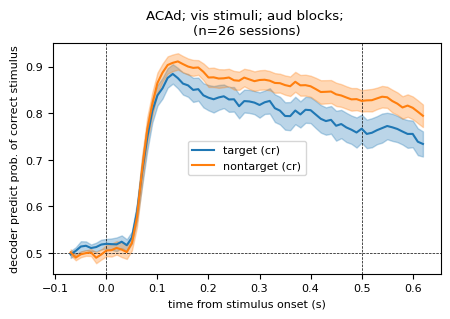

In [186]:
#plot target vs. nontarget cr (non-rewarded blocks)

sel_structure='ACAd'
sel_modality='vis'

if sel_modality=='vis':
    sel_result='vis_stim_all_blocks'
    sel_stim_names=['vis1','vis2']
    sel_is_vis_rewarded=False
    block_type='aud'
elif sel_modality=='aud':
    sel_result='aud_stim_all_blocks'
    sel_stim_names=['sound1','sound2']
    sel_is_vis_rewarded=True
    block_type='vis'

sel_is_response=False

target_predict_proba=np.vstack(
    trial_type_table_df.query(
    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[0]}" and \
    results_key=="{sel_result}"')['predict_proba'].values)

nontarget_predict_proba=np.vstack(
    trial_type_table_df.query(
    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[1]}" and \
    results_key=="{sel_result}"')['predict_proba'].values)
nontarget_predict_proba=1-nontarget_predict_proba

timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[0]}" and \
                                    results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
ax.plot(timepoints,np.nanmean(target_predict_proba,axis=0),label='target (cr)', color='tab:blue')
ax.fill_between(timepoints, np.nanmean(target_predict_proba,axis=0)-stats.sem(target_predict_proba,axis=0,nan_policy='omit'), 
                np.nanmean(target_predict_proba,axis=0)+stats.sem(target_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:blue')
ax.plot(timepoints,np.nanmean(nontarget_predict_proba,axis=0),label='nontarget (cr)', color='tab:orange')
ax.fill_between(timepoints, np.nanmean(nontarget_predict_proba,axis=0)-stats.sem(nontarget_predict_proba,axis=0,nan_policy='omit'), 
                np.nanmean(nontarget_predict_proba,axis=0)+stats.sem(nontarget_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:orange')
ax.legend()
ax.set_title(f"{sel_structure}; {sel_modality} stimuli; {block_type} blocks; \n(n={target_predict_proba.shape[0]} sessions)")
ax.set_xlabel('time from stimulus onset (s)')
ax.set_ylabel('decoder predict prob. of correct stimulus')

In [187]:
#plot nontarget fa vs cr

# sel_structure='MOs'
# sel_modality='aud'

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\figures"

for sel_structure in trial_type_table_df['structure'].unique():
        
    for sel_modality in ['vis','aud']:

        if sel_modality=='vis':
            sel_result='vis_stim_all_blocks'
            sel_stim_name='vis2'
            sel_is_vis_rewarded=True
            block_type='vis'
        elif sel_modality=='aud':
            sel_result='aud_stim_all_blocks'
            sel_stim_name='sound2'
            sel_is_vis_rewarded=False
            block_type='aud'

        sel_is_response=[False,True]

        cr_predict_proba=1-np.vstack(
            trial_type_table_df.query(
            f'structure=="{sel_structure}" and is_response=={sel_is_response[0]} and \
            is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
            results_key=="{sel_result}"')['predict_proba'].values)

        fa_predict_proba=1-np.vstack(
            trial_type_table_df.query(
            f'structure=="{sel_structure}" and is_response=={sel_is_response[1]} and \
            is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
            results_key=="{sel_result}"')['predict_proba'].values)


        timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                            is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[0]}" and \
                                            results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.plot(timepoints,np.nanmean(cr_predict_proba,axis=0),label='cr', color='tab:blue')
        ax.fill_between(timepoints, np.nanmean(cr_predict_proba,axis=0)-stats.sem(cr_predict_proba,axis=0,nan_policy='omit'), 
                        np.nanmean(cr_predict_proba,axis=0)+stats.sem(cr_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:blue')
        ax.plot(timepoints,np.nanmean(fa_predict_proba,axis=0),label='fa', color='tab:red')
        ax.fill_between(timepoints, np.nanmean(fa_predict_proba,axis=0)-stats.sem(fa_predict_proba,axis=0,nan_policy='omit'), 
                        np.nanmean(fa_predict_proba,axis=0)+stats.sem(fa_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:red')
        ax.legend()
        ax.set_title(f"{sel_structure}; {sel_modality} nontarget; {block_type} blocks; \n(n={cr_predict_proba.shape[0]} sessions)")
        ax.set_xlabel('time from stimulus onset (s)')
        ax.set_ylabel('decoder predict prob. of nontarget stimulus')

        fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_modality}_nontarget_cr_fa_decoding_{sel_result}.png"))
        plt.close(fig)

c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encounte

In [ ]:
#plot difference between hit and cr - find first timepoint where hit-cr is significant + save in new table

In [ ]:
#plot modulation of context decoding across stimuli and trial types

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\figures\pdfs"

# sel_structure='MRN'
for sel_structure in trial_type_table_df['structure'].unique():
    # sel_structure='MOs'

    for sel_stim_name in ['vis1','vis2','sound1','sound2']:
        sel_result='response_all_trials_no_baseline_subtract'
        # sel_result='context_all_trials'

        if '1' in sel_stim_name:
            response_type=['hit','cr','fa']
        elif '2' in sel_stim_name:
            response_type=['cr','miss']

        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')

        for rr, sel_response_type in enumerate(response_type):
            if sel_stim_name in ['vis1','vis2']:
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='hit (vis rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    label_str='cr (aud rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='fa (aud rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    if '1' in sel_stim_name:
                        label_str='miss (vis rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (vis rewarded)'
            elif sel_stim_name in ['sound1','sound2']:
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='hit (aud rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    label_str='cr (vis rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='fa (vis rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    if '1' in sel_stim_name:
                        label_str='miss (aud rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (aud rewarded)'
            if sel_response_type=='hit':
                sel_color='tab:green'
            elif sel_response_type=='cr':
                sel_color='tab:blue'
            elif sel_response_type=='fa':
                sel_color='tab:red'
            elif sel_response_type=='miss':
                sel_color='tab:orange'

            predict_proba_values=np.vstack(
                trial_type_table_df.query(
                    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                    results_key=="{sel_result}"')['predict_proba'].values)
            
            # if sel_is_vis_rewarded==False:
            #     predict_proba_values=1-predict_proba_values
            
            # if '2' in sel_stim_name:
            #     predict_proba_values=1-predict_proba_values

            timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                                is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                                                results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

            ax.plot(timepoints,np.nanmean(predict_proba_values,axis=0),label=label_str, color=sel_color)
            ax.fill_between(timepoints, np.nanmean(predict_proba_values,axis=0)-stats.sem(predict_proba_values,axis=0,nan_policy='omit'), 
                            np.nanmean(predict_proba_values,axis=0)+stats.sem(predict_proba_values,axis=0,nan_policy='omit'), alpha=0.3, color=sel_color)
        ax.set_title(f"{sel_structure}; stimulus:{sel_stim_name}; decode:{sel_result}\n(n={predict_proba_values.shape[0]} sessions)")
        ax.set_xlabel('time from stimulus onset (s)')
        ax.set_ylabel('decoder predict prob.')
        # ax.set_ylim([0.2,0.8])
        ax.legend()

        fig.tight_layout()
        
        fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_stim_name}_decoding_by_trial_type_{sel_result}.pdf"))
        plt.close(fig)


c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encounte

In [ ]:
### NEXT STEPS:

# quantify/plot differences between some of these conditions

In [ ]:
#plot context decoding modulation by stimulus name

In [ ]:
# use null shift to compare? (nope, I don't save predict proba for shifts)